# User, Log_data, Loan_result 3개의 테이블 정보 존재
* 1) User : 유저스펙테이블(139만,17)
* 2) Log_data : 유저로그데이터(1784만, 6)
* 3) Loan_result : 대출상품결과 테이블(1353만, 7)

## 1. 기본 아이디어 
* Log_data의 정보를 추출하여 User테이블에 결합하고, Application_id를 기반으로 Loan_result와 merge

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
pd.options.display.max_rows=999
pd.options.display.max_columns=999

In [ ]:
user = pd.read_csv('/최종제출서류/추가제출파일/user_spec.csv')
print(user.shape)
user.head()

(1394216, 17)


,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,NaN,4.0,162000000.0
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,NaN,1.0,27000000.0
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,NaN,5.0,15000000.0
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,NaN,7.0,344000000.0
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394216 entries, 0 to 1394215
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   application_id                       1394216 non-null  int64  
 1   user_id                              1394216 non-null  int64  
 2   birth_year                           1381255 non-null  float64
 3   gender                               1381255 non-null  float64
 4   insert_time                          1394216 non-null  object 
 5   credit_score                         1289101 non-null  float64
 6   yearly_income                        1394126 non-null  float64
 7   income_type                          1394131 non-null  object 
 8   company_enter_month                  1222456 non-null  float64
 9   employment_type                      1394131 non-null  object 
 10  houseown_type                        1394131 non-null  object 
 11

In [ ]:
log_data = pd.read_csv('/최종제출서류/추가제출파일/log_data.csv')
print(log_data.shape)
log_data.head()

(17843993, 6)


,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25


In [ ]:
log_data.isnull().sum()

user_id                0
event                  0
timestamp              0
mp_os                980
mp_app_version    660597
date_cd                0
dtype: int64

In [ ]:
loan_result = pd.read_csv('/최종제출서류/추가제출파일/loan_result.csv')
print(loan_result.shape)
loan_result.tail()

(13527363, 7)


,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied
13527358,1428218,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN
13527359,1428218,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN
13527360,1428218,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN
13527361,1428218,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN
13527362,1428218,2022-06-03 12:01:48,5,194,44000000.0,9.7,NaN


In [ ]:
loan_result.isnull().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257239
dtype: int64

## 2. 유저로그데이터 
* event : 11개 종류의 이벤트
* timestamp : 해당 행동을 한 시간 --> time_gap 파생변수를 만듦
* mp_os : 행동한 디바이스 명
* mp_app_version : 행동한 디바이스 버전명 --> NULL값이 너무 많으므로 제외!

### 1) time_gap : timestamp 컬럼 활용한 파생변수 생성
* 가정1. 이전 행동과 다음 행동 사이에 시간차가 짧은 유저들은 적극적일 것이다 --> 대출 상품을 신청했을 확률이 높다!

In [ ]:
# 우선 str 형태인 timestamp 변수를 datetime형태로 변경
# time_gap 생성 함수 적용

def make_gap(x):
  '''
  time_gap 계산식 : (가장 최근 접속 시간 - 최초 접속 시간) / 접속한 횟수
  28 days 04:43:40 와 같은 형태로 user_id별 time_gap 계산
  --> 차이를 보다 명확하게 구하기 위해 밀리초 단위로 계산
  '''

  gap = (x.max() - x.min()) / x.count()
  cal_milli_seconds = gap.total_seconds() * 1000
  return cal_milli_seconds

log_data['timestamp'] = log_data['timestamp'].astype('datetime64')
time_gap = log_data.groupby('user_id')['timestamp'].apply(lambda x: make_gap(x))
time_gap

user_id
1         7.668748e+08
7         0.000000e+00
9         1.180000e+05
11        1.636624e+08
12        7.816832e+07
              ...     
879693    6.691567e+07
879694    1.091667e+05
879695    4.275000e+04
879696    3.636364e+04
879698    2.666666e+03
Name: timestamp, Length: 584636, dtype: float64

### 2) num_events : 유저별 행동을 수행한 행동 종류의 개수 확인
* 가정 2. event를 많이 수행했을수록 대출상품을 신청했을 확률이 높다고 봄!

### 3) event 원-핫 인코딩 : 유저별로 각 행동을 몇번 수행했는지에 대해 더미 형태로 집계


In [ ]:
# event 종류의 수 --> 11개
log_data['event'].value_counts()

# openApp : 핀다(대출어플) 앱 실행
# EndLoanApply : 한도조회 결과 확인
# GetCreditInfo : KCB 신용정보 조회
# StartLoanApply : 한도조회 시작하기 버튼 클릭
# ViewLoanApplyIntro : 한도조회 인트로 페이지 조회
# UseLoanManage : 대출관리 서비스 이용
# CompleteIDCertification : 본인인증 완료
# SignUp : 회원가입
# UsePrepayCalc : 여윳돈 계산기 서비스 이용
# UseDSRCalc : DSR 계산기(연간 소득에서 갚아야하는 부채의 비율) 서비스 이용

OpenApp                    3460762
EndLoanApply               2715253
GetCreditInfo              2661997
Login                      2463755
StartLoanApply             1893914
ViewLoanApplyIntro         1804712
UseLoanManage              1558906
CompleteIDCertification    1237777
SignUp                       34892
UsePrepayCalc                 7360
UseDSRCalc                    4665
Name: event, dtype: int64

In [ ]:
# num_events 생성
# user_id 기준으로 nunique를 통해 행동에 대한 횟수 확인
num_events = log_data.groupby('user_id')['event'].nunique()
num_events

print(f'행동 횟수 value_counts : {num_events.value_counts()}')

행동 횟수 value_counts : 8     142178
1     131819
7      76227
4      58970
6      53851
5      44696
3      38718
2      26446
9      11539
10       180
11        12
Name: event, dtype: int64


In [ ]:
# event 원-핫 인코딩
# 유저별로 각 행동을 수행한 횟수를 더미 형태로 집계
event_cat = log_data.groupby(['user_id', 'event'])['user_id'].agg(len).unstack().fillna(0)
event_cat

event,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro
user_id,,,,,,,,,,,
1,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,4.0,7.0,8.0,0.0,5.0,0.0,4.0,0.0,9.0,1.0,5.0
12,15.0,39.0,5.0,15.0,15.0,0.0,15.0,0.0,1.0,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...
879693,6.0,12.0,2.0,0.0,9.0,0.0,17.0,0.0,5.0,0.0,10.0
879694,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
879695,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 2. user_log : 생성한 time_gap, num_events, event 원-핫 인코딩에 대해서 user 테이블과 병합
* LEFT MERGE


In [ ]:
add_list = [num_events, time_gap, event_cat]

def merge_user_log(df=None, *add_list):
  for add in add_list:
    df = pd.merge(df, add, on='user_id', how='left')
  
  return df

user_log = merge_user_log(user, *add_list)

user_log.rename(columns={'event' : 'num_event', 'timestamp' : 'time_gap'}, inplace=True)
print(user_log.shape)
user_log.head()

(1394216, 30)


,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,NaN,4.0,162000000.0,1.0,2.436220e+09,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,NaN,1.0,27000000.0,8.0,1.446101e+08,3.0,3.0,7.0,5.0,4.0,0.0,3.0,0.0,2.0,0.0,3.0
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,NaN,5.0,15000000.0,8.0,7.040652e+07,2.0,5.0,3.0,3.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,NaN,7.0,344000000.0,8.0,1.042796e+08,6.0,8.0,5.0,8.0,8.0,0.0,7.0,0.0,3.0,0.0,8.0
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0,7.0,5.118580e+07,10.0,13.0,12.0,0.0,19.0,0.0,11.0,0.0,18.0,0.0,14.0


## 3. user_log 테이블 전처리
* 1) personal_rehabilitation, personal_rehabilitation_complete_yn 컬럼 처리
* 2) birthyear 컬럼 -> 나이를 나타내는 age / 세대를 나타내는 age_group 파생변수 생성
### 결측치 처리
* 3) purpose 컬럼 -> 데이터명 한/영 통합(한글로) -> 결측치는 age_group으로 group_by 후 그룹별 최대값 적용
* 4) gender & company_enter_month & employment_type & income_type & houseown_type & -> Unknown
* credit_score & yearly_income & desired_amount & extisting_laon_ent & existing_loan_amt --> age_group으로 groupby후 그룹별 평균값 적용
* 5) 파생변수 결측치 --> -1로 대체
### 파생변수 생성 및 기존 컬럼 제거
* 6) income_type + employment_type --> 묶어 주기
* 7) yearly_income / age --> 파생변수 생성
* 8) existing_loan_amt / existing_loan_cnt --> 평균 기대출금액 파생변수 생성
* 9) birth_year 및 age , income_type 및 employment_type 컬럼 삭제


In [ ]:
user_log.info()

print('\n\n', '-'*70)
print(f"user_id 개수 : {user_log['user_id'].nunique()}")
print(f"application_id 개수 : {user_log['application_id'].nunique()}")
# insert_time : 아이디 생성일시
# credit_score : 한도조회 당시 유저 신용점수
# yearly_income : 연소득
# income_type : 근로형태
# company_enter_month : 입사연월
# employment_type : 고용형태
# houseown_type : 주거소유형태
# desired_amount : 대출희망금액(100만단위 반올림)
# purpose : 대출 목적
# existing_loan_cnt : 기대출수(기존에 대출한 횟수)
# existing_loan_amt : 기대출금액(기존에 대출한 금액)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394216 entries, 0 to 1394215
Data columns (total 30 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   application_id                       1394216 non-null  int64  
 1   user_id                              1394216 non-null  int64  
 2   birth_year                           1381255 non-null  float64
 3   gender                               1381255 non-null  float64
 4   insert_time                          1394216 non-null  object 
 5   credit_score                         1289101 non-null  float64
 6   yearly_income                        1394126 non-null  float64
 7   income_type                          1394131 non-null  object 
 8   company_enter_month                  1222456 non-null  float64
 9   employment_type                      1394131 non-null  object 
 10  houseown_type                        1394131 non-null  object 
 11

### 1) 개인회생자여부, 개인회생자 납입완료 여부
* personal_rehabilitation_yn, personal_rehabilitation_complete_yn
* 각 컬럼에 대해 결측치를 0으로 대체
* 두 컬럼의 값을 더한 rehabilitation_total 파생변수 생성
* 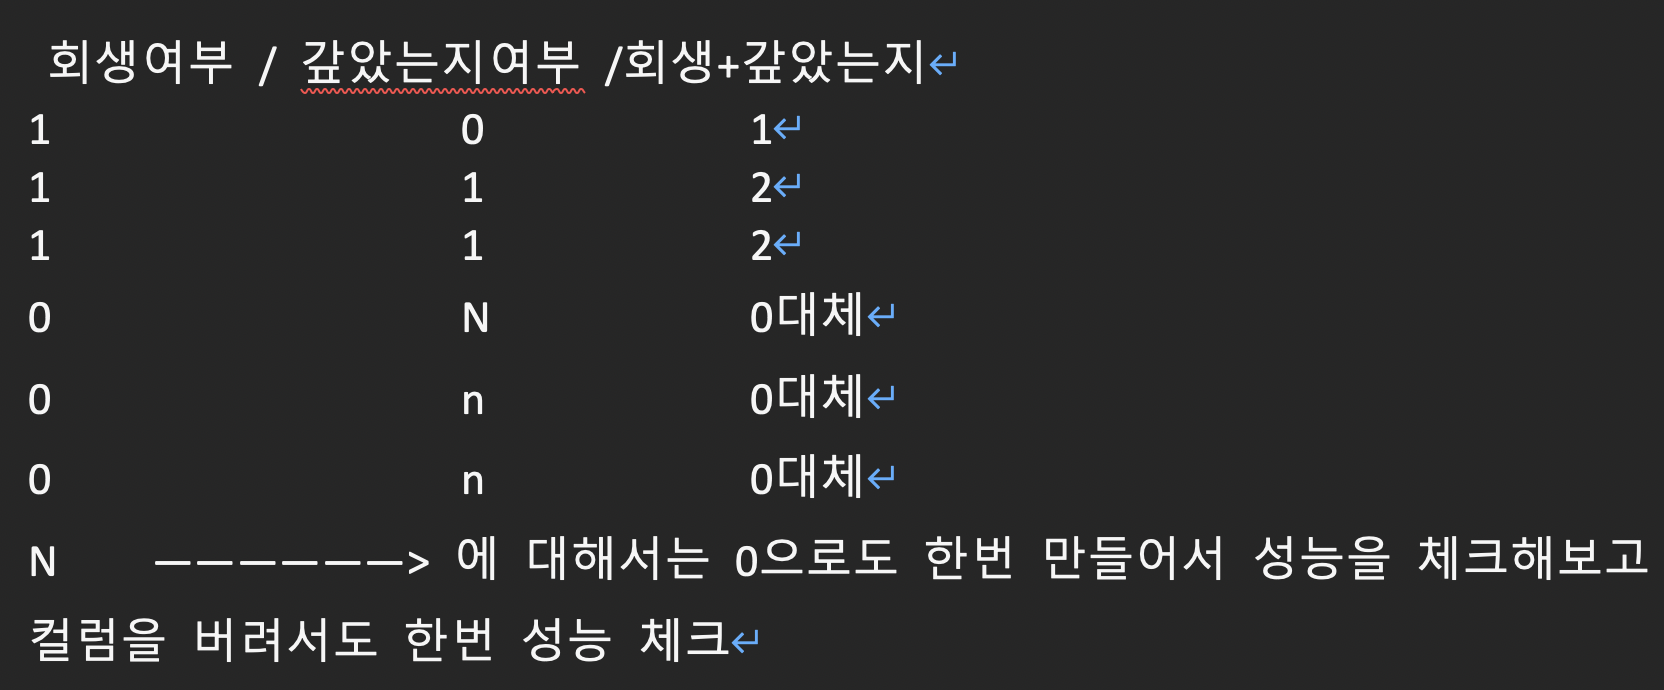

In [ ]:
def rehabilitation_prepro(df=None):
  '''
  개인 회생자 여부, 개인 회생자 납입완료 여부 컬럼 전처리
  1) 두 컬럼에 대해 null값은 0으로 대체
  2) rehabilitation_total 컬럼을 만들어 회생 + 납입 계산
   ---> 회생자이고 못갚았으면 1
   ---> 회생자이고 갚았으면 2
   ---> 애초에 회생자가 아니면 0
  의 값을 가지게 될 것
  '''  
  rehabilitation_list = ['personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn']

  for column in rehabilitation_list:
    df[column].fillna(0, inplace=True)
  
  df['rehabailitation_total'] = df['personal_rehabilitation_yn'] + df['personal_rehabilitation_complete_yn']
  return df

user_log_2 = rehabilitation_prepro(user_log)

### 2) 유저 생년월일(birth_year)
* 생년월일 --> 유저별 나이를 표시하는 age 파생변수 생성
* age 기준별로 나누어 세대 그룹을 표현할 수 있는 age_group 파생변수 생성


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


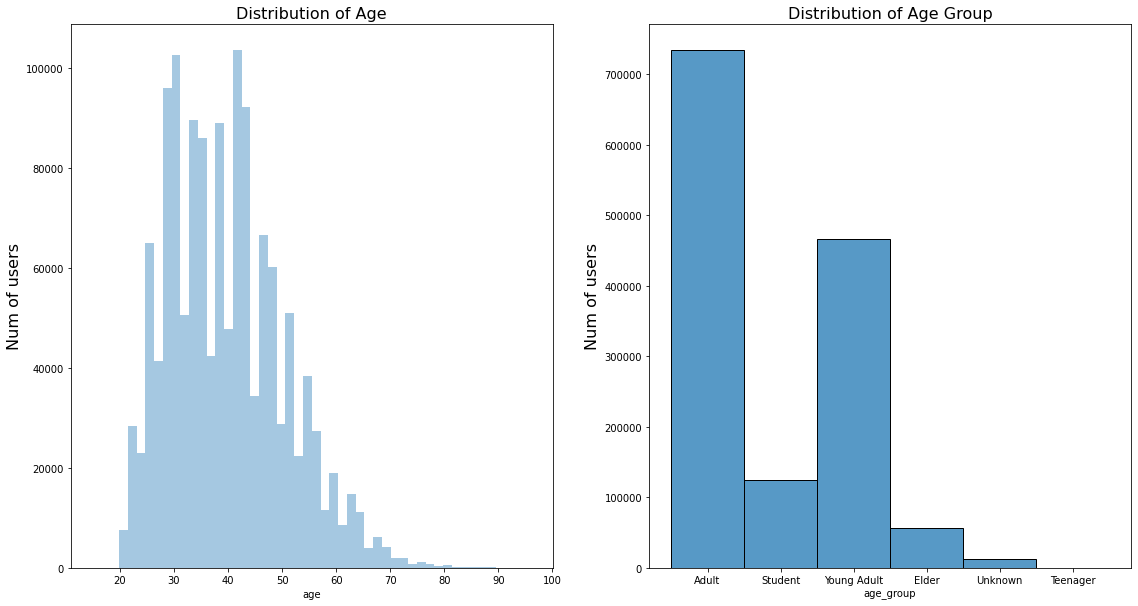

In [ ]:
# 올해(2022년) 기준 유저들의 나이를 구하고, Age_group으로 분류해줌!

def get_age(x):
  '''
  유저들의 나이를 구하는 함수
  '''
  age = 2022 - x + 1

  return age

def age_group(x):
  '''
  get_age 함수를 가져온 후 연령대 그룹별로 분류
  null인 것들은 Unknown으로 분류! 
  '''
  age = get_age(x)

  if age <= 19 : 
    cat = 'Teenager'
  
  elif age <= 26 :
    cat = 'Student'
  
  elif age <= 36:
    cat = 'Young Adult'
  
  elif age <= 60:
    cat = 'Adult' 

  elif age <= 100:
    cat = 'Elder'

  else : 
    cat = 'Unknown'

  return cat


user_log_2['age'] = user_log_2['birth_year'].apply(lambda x: get_age(x))
user_log_2['age_group'] = user_log_2['birth_year'].apply(lambda x: age_group(x))


# Age / Age_group 의 유저 분포 확인
plt.figure(figsize=(19,10))
plt.subplot(1,2,1)
plt.title('Distribution of Age', fontsize=16)
sns.distplot(user_log_2['age'], kde=False)
plt.ylabel('Num of users', fontsize=16)

plt.subplot(1,2,2)
plt.title('Distribution of Age Group', fontsize=16)
sns.histplot(user_log_2['age_group'])
plt.ylabel('Num of users', fontsize=16)
plt.show()

### 3) purpose 컬럼
* 한/영 으로 나누어져 있는 것 한글로 통합
* 결측치는 age_group별로 groupby --> 각 age_group별 최대 빈도값으로 대체


In [ ]:
# 생활비 - LIVING  / 대환대출 - SWITCHLOAN 와 같이 동일 카테고리가 한/영으로 구분되어 있다
user_log_2['purpose'].value_counts()

생활비             866079
대환대출            353794
사업자금             62115
기타               30132
전월세보증금           27236
주택구입             17471
LIVING           15432
투자               12532
자동차구입             3394
SWITCHLOAN        3248
BUSINESS           935
ETC                593
HOUSEDEPOSIT       562
BUYHOUSE           307
INVEST             166
BUYCAR             135
Name: purpose, dtype: int64

In [ ]:
# 앞서 지정한 연령대 그룹별 최대값을 가진 purpose로 NULL값 대체
# Teenager - 생활비 / Student - 생활비 / Young Adult -  생활비  / Adult - 생활비   / Elder -  생활비  / Unknown  -  생활비
user_log_2.groupby(['age_group', 'purpose'])['purpose'].count()

age_group    purpose     
Adult        BUSINESS           532
             BUYCAR              51
             BUYHOUSE           151
             ETC                307
             HOUSEDEPOSIT       173
             INVEST              52
             LIVING            8518
             SWITCHLOAN        1793
             기타               16157
             대환대출            187884
             사업자금             38681
             생활비             453059
             자동차구입             1427
             전월세보증금           11036
             주택구입              8993
             투자                5615
Elder        BUSINESS            56
             BUYCAR               5
             BUYHOUSE             8
             ETC                 44
             HOUSEDEPOSIT        13
             INVEST              30
             LIVING            1618
             SWITCHLOAN         200
             기타                1532
             대환대출              9854
             사업자금              3381
  

In [ ]:
def purpose_prepro(df=None, **purpose_rep):
  '''
  purpose 컬럼에 대한 전체적인 전처리를 수행하는 함수
  '''

  print(f"변경 전 purpose 컬럼 종류: {df['purpose'].value_counts()}")
  print('\n', '-'* 70)

  df.replace(purpose_rep, inplace=True)
  df['purpose'].fillna('생활비', inplace=True)
  print('null값 개수 : ', df['purpose'].isnull().sum())
  print('변경 후 purpose 컬럼 종류 : ', df['purpose'].value_counts())
  
  return df


purpose_rep = {'purpose' : {'LIVING' : '생활비', 'SWITCHLOAN' : '대환대출', 'BUSINESS' : '사업자금', 'ETC' : '기타', 
                            'HOUSEDEPOSIT' : '전월세보증금', 'BUYHOUSE' : '주택구입', 'INVEST' : '투자', 'BUYCAR' : '자동차구입'
                            }
               }

user_log_2 = purpose_prepro(user_log_2, **purpose_rep)

user_log_2.head()

변경 전 purpose 컬럼 종류: 생활비             866079
대환대출            353794
사업자금             62115
기타               30132
전월세보증금           27236
주택구입             17471
LIVING           15432
투자               12532
자동차구입             3394
SWITCHLOAN        3248
BUSINESS           935
ETC                593
HOUSEDEPOSIT       562
BUYHOUSE           307
INVEST             166
BUYCAR             135
Name: purpose, dtype: int64

 ----------------------------------------------------------------------
null값 개수 :  0
변경 후 purpose 컬럼 종류 :  생활비       881596
대환대출      357042
사업자금       63050
기타         30725
전월세보증금     27798
주택구입       17778
투자         12698
자동차구입       3529
Name: purpose, dtype: int64


,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,rehabailitation_total,age,age_group
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,0.0,4.0,162000000.0,1.0,2.436220e+09,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,Adult
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,0.0,1.0,27000000.0,8.0,1.446101e+08,3.0,3.0,7.0,5.0,4.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,55.0,Adult
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,0.0,5.0,15000000.0,8.0,7.040652e+07,2.0,5.0,3.0,3.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,26.0,Student
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,0.0,7.0,344000000.0,8.0,1.042796e+08,6.0,8.0,5.0,8.0,8.0,0.0,7.0,0.0,3.0,0.0,8.0,0.0,34.0,Young Adult
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0,7.0,5.118580e+07,10.0,13.0,12.0,0.0,19.0,0.0,11.0,0.0,18.0,0.0,14.0,0.0,23.0,Student


### 4) 나머지 컬럼 전처리
* 범주형 컬럼(gender & company_enter_month & employment_type & income_type & houseown_type) 결측치 -> Unknown 으로 대체
* 수치형 컬럼(credit_score & yearly_income & desired_amount & existing_loan_cnt & existing_loan_amt) 결측치 -> age_group으로 groupby후 그룹별 평균값으로 대체

In [ ]:
def fill_na(df=None, *na_columns):
  '''
  위 범주형 /수치형 컬럼들에 대해 결측치를 대체하는 함수
  na_columns : 컬럼 리스트
  '''

  for column in na_columns:
    
    if (column == 'gender') or (column == 'company_enter_month') or (column == 'employment_type') or (column == 'income_type') or (column == 'houseown_type'):
      df[column].fillna('Unknown', inplace=True)

    else:
      mean_age_group = df.groupby('age_group')[column].transform('mean')
      df[column].fillna(mean_age_group, inplace=True)

  return df

na_columns = ['gender', 'company_enter_month', 'employment_type', 'income_type', 'houseown_type',
           'credit_score', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']

user_log_2 = fill_na(user_log_2, *na_columns)

user_log_2.head()

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,rehabailitation_total,age,age_group
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,20151101.0,기타,자가,1000000.0,기타,0.0,0.0,4.0,162000000.0,1.0,2.436220e+09,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,Adult
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,20070201.0,정규직,기타가족소유,30000000.0,대환대출,0.0,0.0,1.0,27000000.0,8.0,1.446101e+08,3.0,3.0,7.0,5.0,4.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,55.0,Adult
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,20210901.0,기타,기타가족소유,10000000.0,생활비,0.0,0.0,5.0,15000000.0,8.0,7.040652e+07,2.0,5.0,3.0,3.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,26.0,Student
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,20170101.0,정규직,자가,2000000.0,생활비,0.0,0.0,7.0,344000000.0,8.0,1.042796e+08,6.0,8.0,5.0,8.0,8.0,0.0,7.0,0.0,3.0,0.0,8.0,0.0,34.0,Young Adult
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,20210901.0,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0,7.0,5.118580e+07,10.0,13.0,12.0,0.0,19.0,0.0,11.0,0.0,18.0,0.0,14.0,0.0,23.0,Student


In [ ]:
user_log_2.isnull().sum()

application_id                             0
user_id                                    0
birth_year                             12961
gender                                     0
insert_time                                0
credit_score                               0
yearly_income                              0
income_type                                0
company_enter_month                        0
employment_type                            0
houseown_type                              0
desired_amount                             0
purpose                                    0
personal_rehabilitation_yn                 0
personal_rehabilitation_complete_yn        0
existing_loan_cnt                          0
existing_loan_amt                        114
num_event                              38810
time_gap                               38810
CompleteIDCertification                38810
EndLoanApply                           38810
GetCreditInfo                          38810
Login     

In [ ]:
# existing_loan_amt 컬럼 NULL값 여전히 존재 
# --> Teenager 그룹의 existing_loan_amt 평균이 NaN
# --> 0으로 대체
print(user_log_2.groupby('age_group')['existing_loan_amt'].mean())

user_log_2['existing_loan_amt'].fillna(0, inplace=True)

age_group
Adult          8.670648e+07
Elder          6.137215e+07
Student        2.665109e+07
Teenager                NaN
Unknown        6.018039e+07
Young Adult    5.549966e+07
Name: existing_loan_amt, dtype: float64


### 5) 파생변수 결측치 처리
* num_event, time_gap --> -1로 null값 대체
* event_cat --> 0으로 null값 대체

In [ ]:
na_columns_2 = ['num_event', 'time_gap']
na_columns_3 = ['CompleteIDCertification', 'EndLoanApply', 'GetCreditInfo',
       'Login', 'OpenApp', 'SignUp', 'StartLoanApply', 'UseDSRCalc',
       'UseLoanManage', 'UsePrepayCalc', 'ViewLoanApplyIntro']

for column in na_columns_2:
  user_log_2[column].fillna(-1, inplace=True)

for column in na_columns_3:
  user_log_2[column].fillna(0, inplace=True)

user_log_2.isnull().sum()

application_id                             0
user_id                                    0
birth_year                             12961
gender                                     0
insert_time                                0
credit_score                               0
yearly_income                              0
income_type                                0
company_enter_month                        0
employment_type                            0
houseown_type                              0
desired_amount                             0
purpose                                    0
personal_rehabilitation_yn                 0
personal_rehabilitation_complete_yn        0
existing_loan_cnt                          0
existing_loan_amt                          0
num_event                                  0
time_gap                                   0
CompleteIDCertification                    0
EndLoanApply                               0
GetCreditInfo                              0
Login     

### 파생변수 생성 및 기존 컬럼 삭제
* 6) income_type + employment_type --> 묶어 주기
* 7) company_enter_month 기본 전처리
* 8) yearly_income / age --> 파생변수 생성
* 9) existing_loan_amt / existing_loan_cnt --> 평균 기대출금액 파생변수 생성

In [ ]:
def income_employment_prepro(col_1, col_2, df=None):
  '''
  6) income_type + employment_type 묶어주기
  '''
  df['income_employment_type'] = df[col_1] + ',' + df[col_2]
  return df

def company_enter_month_prepro(x):
  '''
  7) company_enter_month 기본 전처리
  Unknown 값에 대해서는 0으로 변환
  나머지는 199612 등과 같은 형태로 전처리
  '''
  if x == 'Unknown':
    year_month = 0
  
  else:
    year_month = str(x)[:6]
  
  return year_month

def year_income_age(col_1, col_2, df=None):
  '''
  8) yearly_income / age 파생변수 생성
  age null값 --> 일단 0으로 변환
  0/0은 Nan 처리가 된다 --> 따라서 0으로 fillna
  '''
  df_2 = df.copy()
  df_2[col_1].fillna(0, inplace=True)
  df_2['year_income_age'] = df_2[col_2] / df_2[col_1]
  df_2['year_income_age'] = df_2['year_income_age'].apply(lambda x: x if x != np.inf else 0)
  df_2['year_income_age'].fillna(0, inplace=True)
  
  return df_2

def loan_amt_avg(col_1, col_2, df=None):
  '''
  9) 평균 기대출금액 파생변수 생성
  '''
  df['existing_avg_loan_amt'] = df[col_1] / df[col_2]
  return df




user_log_2 = income_employment_prepro('income_type', 'employment_type', user_log_2)
user_log_2 = loan_amt_avg('existing_loan_amt', 'existing_loan_cnt', user_log_2)
user_log_2 = year_income_age('age', 'yearly_income', user_log_2)
user_log_2['company_enter_month'] = user_log_2['company_enter_month'].apply(lambda x: company_enter_month_prepro(x))
user_log_2.head()

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,rehabailitation_total,age,age_group,income_employment_type,existing_avg_loan_amt,year_income_age
0,1249046,118218,1985.0,1.0,2022-06-07 06:28:18,660.0,108000000.0,PRIVATEBUSINESS,201511,기타,자가,1000000.0,기타,0.0,0.0,4.0,162000000.0,1.0,2.436220e+09,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,Adult,"PRIVATEBUSINESS,기타",4.050000e+07,2.842105e+06
1,954900,553686,1968.0,1.0,2022-06-07 14:29:03,870.0,30000000.0,PRIVATEBUSINESS,200702,정규직,기타가족소유,30000000.0,대환대출,0.0,0.0,1.0,27000000.0,8.0,1.446101e+08,3.0,3.0,7.0,5.0,4.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,55.0,Adult,"PRIVATEBUSINESS,정규직",2.700000e+07,5.454545e+05
2,137274,59516,1997.0,1.0,2022-06-07 21:40:22,710.0,30000000.0,FREELANCER,202109,기타,기타가족소유,10000000.0,생활비,0.0,0.0,5.0,15000000.0,8.0,7.040652e+07,2.0,5.0,3.0,3.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,26.0,Student,"FREELANCER,기타",3.000000e+06,1.153846e+06
3,1570936,167320,1989.0,1.0,2022-06-07 09:40:27,820.0,62000000.0,EARNEDINCOME,201701,정규직,자가,2000000.0,생활비,0.0,0.0,7.0,344000000.0,8.0,1.042796e+08,6.0,8.0,5.0,8.0,8.0,0.0,7.0,0.0,3.0,0.0,8.0,0.0,34.0,Young Adult,"EARNEDINCOME,정규직",4.914286e+07,1.823529e+06
4,967833,33400,2000.0,1.0,2022-06-07 08:55:07,630.0,36000000.0,EARNEDINCOME,202109,정규직,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0,7.0,5.118580e+07,10.0,13.0,12.0,0.0,19.0,0.0,11.0,0.0,18.0,0.0,14.0,0.0,23.0,Student,"EARNEDINCOME,정규직",1.600000e+07,1.565217e+06


### 10) birth_year 및 age , income_type 및 employment_type 컬럼 제거
* age_group, income_employment_type 파생변수를 만들어 주었으므로 drop 해당 컬럼 제거

In [ ]:
user_log_2.drop(columns=['birth_year', 'age', 'income_type', 'employment_type'], inplace=True)
print(user_log_2.shape)
user_log_2.head()

(1394216, 32)


,application_id,user_id,gender,insert_time,credit_score,yearly_income,company_enter_month,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,rehabailitation_total,age_group,income_employment_type,existing_avg_loan_amt,year_income_age
0,1249046,118218,1.0,2022-06-07 06:28:18,660.0,108000000.0,201511,자가,1000000.0,기타,0.0,0.0,4.0,162000000.0,1.0,2.436220e+09,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Adult,"PRIVATEBUSINESS,기타",4.050000e+07,2.842105e+06
1,954900,553686,1.0,2022-06-07 14:29:03,870.0,30000000.0,200702,기타가족소유,30000000.0,대환대출,0.0,0.0,1.0,27000000.0,8.0,1.446101e+08,3.0,3.0,7.0,5.0,4.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,Adult,"PRIVATEBUSINESS,정규직",2.700000e+07,5.454545e+05
2,137274,59516,1.0,2022-06-07 21:40:22,710.0,30000000.0,202109,기타가족소유,10000000.0,생활비,0.0,0.0,5.0,15000000.0,8.0,7.040652e+07,2.0,5.0,3.0,3.0,2.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,Student,"FREELANCER,기타",3.000000e+06,1.153846e+06
3,1570936,167320,1.0,2022-06-07 09:40:27,820.0,62000000.0,201701,자가,2000000.0,생활비,0.0,0.0,7.0,344000000.0,8.0,1.042796e+08,6.0,8.0,5.0,8.0,8.0,0.0,7.0,0.0,3.0,0.0,8.0,0.0,Young Adult,"EARNEDINCOME,정규직",4.914286e+07,1.823529e+06
4,967833,33400,1.0,2022-06-07 08:55:07,630.0,36000000.0,202109,기타가족소유,5000000.0,생활비,0.0,0.0,1.0,16000000.0,7.0,5.118580e+07,10.0,13.0,12.0,0.0,19.0,0.0,11.0,0.0,18.0,0.0,14.0,0.0,Student,"EARNEDINCOME,정규직",1.600000e+07,1.565217e+06


## 4. user_log 테이블과 loan_result 테이블 merge
* on='application_id'

In [ ]:
final_df = pd.merge(user_log_2, loan_result, on='application_id', how='right')
print(final_df.shape)
final_df.head()

## 5. final_df 테이블 전처리
* 1) user_id ~ year_income_age 컬럼에 대해 공통으로 NULL값 있는 113개의 row 제거
* 2) loan_limit, loan_rate 컬럼 --> 0으로 결측치 대체
* 3) 연속형 변수 전처리 : 연속형 변수에 이상치(IQR기준)제거 후 StandardScaler와 MinMaxScaler 적용 
* 4) LabelEncoder(범주형 변수 전처리) --> gender, company_enter_month, houseown_type, purpose, income_employment_type
* 5) 시간 타입 변수 전처리 : insert_time, loan_apply_insert_time 컬럼 --> 연월일시분초로 각각 컬럼 분리 후 insert_time은 연월일만 남기고 loan_apply_insert_time은 day, hour, minute 3개만 남길 것!

In [ ]:
# 1) user_id ~ year_income_age 컬럼이 NULL인 Row는 Drop

final_check_columns = ['user_id', 'gender']

final_df_2 = final_df.dropna(axis=0, subset=final_check_columns)
final_df_2.isnull().sum()

In [ ]:
# 2) loan_limit, loan_rate 컬럼의 NULL값 --> 0으로 fillna

def loan_prepro(df=None):
  columns = ['loan_limit', 'loan_rate']

  for column in columns:
    df[column].fillna(0, inplace=True)
  
  return df

final_df_2 = loan_prepro(final_df_2)

In [ ]:
# test 데이터 따로 저장
test = final_df_2[final_df_2['is_applied'].isnull()]

In [ ]:
test.to_csv('test_ver02.csv', index=False)

In [ ]:
# 3) 연속형 변수 --> Scaler 사용 
# 먼저 이상치 탐색 후 제거
# 그 다음으로 정규화(Standard) +  표준화(MinMax) 수행
# 연속형 변수 : 신용점수, 연소득, 대출희망금액, 기대출금액, 평균기대출금액(파생), 연소득/나이(파생), 대출승인한도

def check_outliers(df, weight=1.5):
  
  numeric_columns = ['credit_score', 'yearly_income', 'desired_amount', 'existing_loan_amt', 
             'existing_avg_loan_amt', 'year_income_age', 'loan_limit']
  
  for column in numeric_columns:
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)
    quantile_75 = np.percentile(data.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weights = iqr * weight

    lowest_value = quantile_25 - iqr_weights
    highest_value = quantile_75 + iqr_weights

    outlier_index = df[(data < lowest_value) | (data > highest_value)].index
    df.drop(outlier_index, axis=0, inplace=True)
  return df

final_df_2 = check_outliers(final_df_2)
print(final_df_2.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(9560926, 38)


In [ ]:
# 이상치 날아간 train 데이터 --> Scaler 사용 --> MinMaxScaler 또는 StandardScaler 사용
# test 데이터
# 연속형 변수 : 신용점수

def scale_normalize(df=None, method='None'):

  numeric_columns = ['credit_score', 'yearly_income', 'desired_amount', 'existing_loan_amt', 
             'existing_avg_loan_amt', 'year_income_age', 'loan_limit'
             ]
    
  if method == 'Standard':
    scaler = StandardScaler()
    scaler.fit(df[numeric_columns])
    df[numeric_columns] = scaler.transform(df[numeric_columns])

  elif method == 'MinMax':
    scaler = MinMaxScaler()
    scaler.fit(df[numeric_columns])
    df[numeric_columns] = scaler.transform(df[numeric_columns])
  
  else:
    pass
  
  return df

final_df_3 = scale_normalize(final_df_2, method='Standard')
final_df_4 = scale_normalize(final_df_3, method='MinMax')
test = scale_normalize(test, method='Standard')
test = scale_normalize(test, method='MinMax')
final_df_4.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,application_id,user_id,gender,insert_time,credit_score,yearly_income,company_enter_month,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,num_event,time_gap,CompleteIDCertification,EndLoanApply,GetCreditInfo,Login,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro,rehabailitation_total,age_group,income_employment_type,existing_avg_loan_amt,year_income_age,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied
0,1748340,430982.0,1.0,2022-06-07 13:05:39,0.424242,0.296296,202202,자가,0.227273,대환대출,0.0,0.0,2.0,0.086705,176.0,2.124223e+07,15.0,50.0,2.0,0.0,42.0,0.0,50.0,0.0,1.0,0.0,16.0,0.0,Young Adult,"EARNEDINCOME,정규직",0.170455,0.452242,2022-06-07 13:05:41,7,191,0.688525,13.6,NaN
1,1748340,430982.0,1.0,2022-06-07 13:05:39,0.424242,0.296296,202202,자가,0.227273,대환대출,0.0,0.0,2.0,0.086705,176.0,2.124223e+07,15.0,50.0,2.0,0.0,42.0,0.0,50.0,0.0,1.0,0.0,16.0,0.0,Young Adult,"EARNEDINCOME,정규직",0.170455,0.452242,2022-06-07 13:05:41,25,169,0.393443,17.9,NaN
2,1748340,430982.0,1.0,2022-06-07 13:05:39,0.424242,0.296296,202202,자가,0.227273,대환대출,0.0,0.0,2.0,0.086705,176.0,2.124223e+07,15.0,50.0,2.0,0.0,42.0,0.0,50.0,0.0,1.0,0.0,16.0,0.0,Young Adult,"EARNEDINCOME,정규직",0.170455,0.452242,2022-06-07 13:05:41,2,7,0.393443,18.5,NaN
3,1748340,430982.0,1.0,2022-06-07 13:05:39,0.424242,0.296296,202202,자가,0.227273,대환대출,0.0,0.0,2.0,0.086705,176.0,2.124223e+07,15.0,50.0,2.0,0.0,42.0,0.0,50.0,0.0,1.0,0.0,16.0,0.0,Young Adult,"EARNEDINCOME,정규직",0.170455,0.452242,2022-06-07 13:05:41,4,268,0.475410,10.8,NaN
4,1748340,430982.0,1.0,2022-06-07 13:05:39,0.424242,0.296296,202202,자가,0.227273,대환대출,0.0,0.0,2.0,0.086705,176.0,2.124223e+07,15.0,50.0,2.0,0.0,42.0,0.0,50.0,0.0,1.0,0.0,16.0,0.0,Young Adult,"EARNEDINCOME,정규직",0.170455,0.452242,2022-06-07 13:05:41,11,118,0.081967,16.4,NaN


In [ ]:
# 4) LabelEncoder --> gender, company_enter_month, houseown_type, purpose, income_employment_type, age_group

def label_encoding(le, df=None):
  
  columns = ['gender', 'company_enter_month', 'houseown_type', 'purpose', 'income_employment_type', 'age_group']

  for column in columns:
    df[column] = le.fit_transform(list(df[column]))
  
  return df

le = LabelEncoder()
final_df_4 = label_encoding(le, final_df_4)
test = label_encoding(le, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 5)  insert_time, loanapply_insert_time 컬럼 
#     --> insert_time은 연월일 정도만 분리하고 loanapply_insert_time은 day, hour, minute 3개만 남길 것!

def time_prepro(df=None):
  columns = ['insert_time', 'loanapply_insert_time']
  
  for column in columns:
    df[column] = df[column].astype('datetime64')
  
  df['insert_year'] = df['insert_time'].dt.year
  df['insert_month'] = df['insert_time'].dt.month
  df['insert_day'] = df['insert_time'].dt.day
  df['loan_day'] = df['loanapply_insert_time'].dt.day
  df['loan_hour'] = df['loanapply_insert_time'].dt.hour
  df['loan_minute'] = df['loanapply_insert_time'].dt.minute

  df.drop(columns=['insert_time', 'loanapply_insert_time'])
  return df

final_df_4 = time_prepro(final_df_4)
test = time_prepro(test)
final_df_4.head()

In [ ]:
print(final_df_4.shape)

In [ ]:
final_df_4.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)